In [1]:
import os
import sys

import numpy as np

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../4_analyze')
from containers import Dataset
from score_query import ScoreQuery
from utils import export, show_side_by_side, load_score_file

sys.path.append('../3_score')
from optimize import Scores

sys.path.append('../1_dock')
from parse_chembl import load_chembl

In [2]:
data = '/scratch/PI/rondror/jbelk'

dock_st = {'B1AR':'2VT4','AR_final':'3B67','TRPV1':'3J5Q'}#1e3g 2pnu 3b68 'B2AR':'2RH1','VEGFR2':'2QU6', 'RORg':'3KYT', 
all_ligs = {p:sorted([l.split('.')[0] for l in os.listdir('{}/{}/unique_ligands'.format(data, p))#]) for p,st in dock_st.items()}
               if l != st+'_lig.mae']) for p,st in dock_st.items()}

glide_dir = 'glide12'
cross = True
ifp_dir = 'ifp/ifp13'

chembl_dir = '/scratch/PI/rondror/jbelk/CHEMBL'

In [3]:
d = Dataset(dock_st.keys(), data, dock_st, chembl_dir)
d.load_docking(glide_dir, ifp_dir, cross)

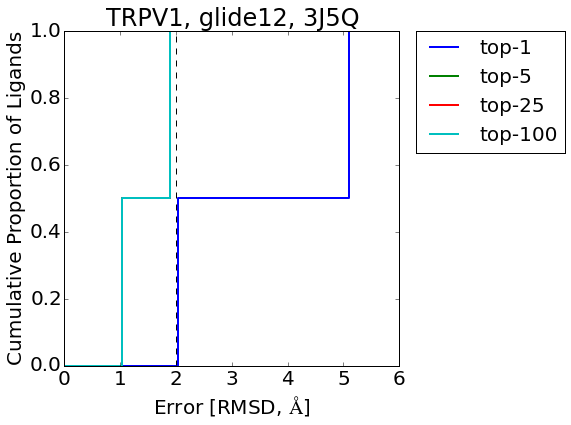

TRPV1 -- top-1: 0, top-100: 2


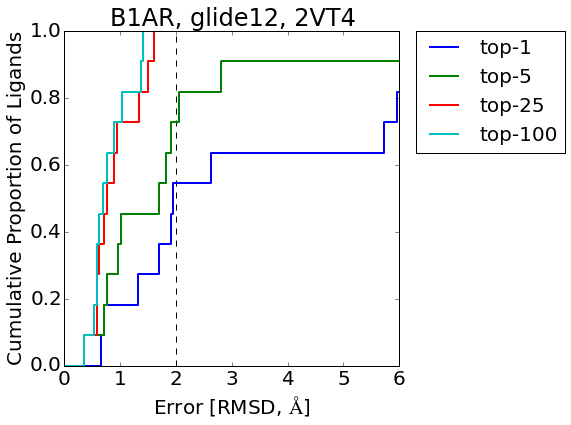

B1AR -- top-1: 6, top-100: 11


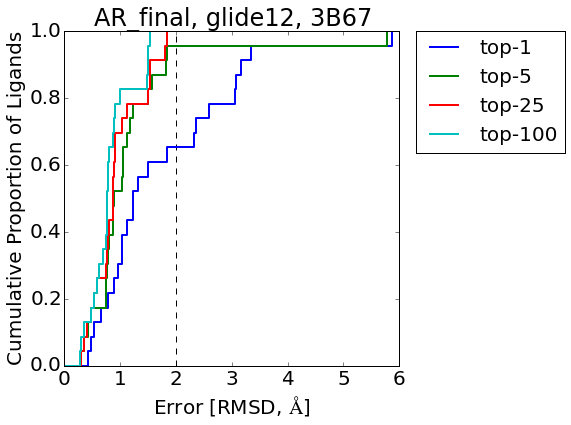

AR_final -- top-1: 15, top-100: 23


In [4]:
# view glide performance

for prot, st in dock_st.items():
    rmsds = d.glide_perf((glide_dir,True), [prot], ligands=all_ligs[prot], show=True, 
                         title='{}, {}, {}'.format(prot, glide_dir, st), n_list=[1,5,25,100])
    print '{} -- top-1: {}, top-100: {}'.format(prot, len([i for i in rmsds[0] if i <=2 and i is not None]), 
                                          len([i for i in rmsds[-1] if i <=2 and i is not None]))

In [5]:
score_file = '{}/{}/scores3/{}/0-0-{}-0.txt'

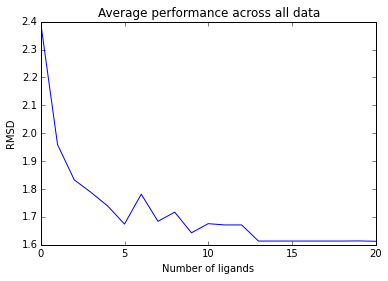

In [6]:
# look at performance vs number of ligands

all_rmsd1 = {}
for n in range(21):
    all_rmsd1[n] = []
    for prot, st in dock_st.items():
        lig_objs = d.all_proteins[prot].docking[(glide_dir, cross)].ligands
        for l in all_ligs[prot]:

            sq1 = load_score_file(score_file.format(data, prot, l, n), lig_objs)
            pose_ranks1 = sorted(sq1.pose_scores.keys(),key=lambda x:-sq1.pose_scores[x])
            us_rmsd1 = sq1.all_lig[l].poses[pose_ranks1[0]].rmsd
            all_rmsd1[n].append(us_rmsd1)
                
plt.plot(range(21), [np.mean(all_rmsd1[n]) for n in range(21)])
plt.xlabel('Number of ligands')
plt.ylabel('RMSD')
plt.title('Average performance across all data')
plt.show()

In [7]:
# load in performance of all ligands for default settings

default_num_lig = 15

all_score_query = {}
for prot, st in dock_st.items():
    lig_objs = d.all_proteins[prot].docking[(glide_dir, cross)].ligands
    for l in all_ligs[prot]:

        all_score_query[l] = load_score_file(score_file.format(data, prot, l, default_num_lig), lig_objs)

In [8]:
# make performance table for all ligands

for prot, st in dock_st.items():
    print '{} docked to {}'.format(prot, st)
    lig_objs = d.all_proteins[prot].docking[(glide_dir, cross)].ligands
    for l in all_ligs[prot]:
        sq = all_score_query[l]
        
        us_pose_ranking = sorted(sq.pose_scores.keys(), key=lambda x: -1*sq.pose_scores[x])
        us_top = lig_objs[l].poses[us_pose_ranking[0]]
        glide_top = lig_objs[l].poses[0]
        
        print l
        print 'Our Pose: {}, Glide Pose: 0'.format(us_top.rank)
        print 'Our RMSD: {}, Glide RMSD: {}'.format(round(us_top.rmsd,2), round(glide_top.rmsd,2))
    print '--------'

TRPV1 docked to 3J5Q
5IRX_lig
Our Pose: 1, Glide Pose: 0
Our RMSD: 1.04, Glide RMSD: 5.1
5IS0_lig
Our Pose: 5, Glide Pose: 0
Our RMSD: 1.98, Glide RMSD: 2.03
--------
B1AR docked to 2VT4
2Y00_lig
Our Pose: 0, Glide Pose: 0
Our RMSD: 9.41, Glide RMSD: 9.41
2Y02_lig
Our Pose: 6, Glide Pose: 0
Our RMSD: 1.61, Glide RMSD: 1.94
2Y03_lig
Our Pose: 19, Glide Pose: 0
Our RMSD: 1.98, Glide RMSD: 5.73
2Y04_lig
Our Pose: 19, Glide Pose: 0
Our RMSD: 0.71, Glide RMSD: 5.96
2YCW_lig
Our Pose: 14, Glide Pose: 0
Our RMSD: 0.67, Glide RMSD: 0.71
2YCZ_lig
Our Pose: 1, Glide Pose: 0
Our RMSD: 0.65, Glide RMSD: 0.66
3ZPQ_lig
Our Pose: 2, Glide Pose: 0
Our RMSD: 2.48, Glide RMSD: 2.63
3ZPR_lig
Our Pose: 16, Glide Pose: 0
Our RMSD: 2.92, Glide RMSD: 1.7
4AMI_lig
Our Pose: 0, Glide Pose: 0
Our RMSD: 1.31, Glide RMSD: 1.31
4AMJ_lig
Our Pose: 0, Glide Pose: 0
Our RMSD: 1.92, Glide RMSD: 1.92
5A8E_lig
Our Pose: 5, Glide Pose: 0
Our RMSD: 0.59, Glide RMSD: 6.23
--------
AR_final docked to 3B67
1E3G_lig
Our Pose:

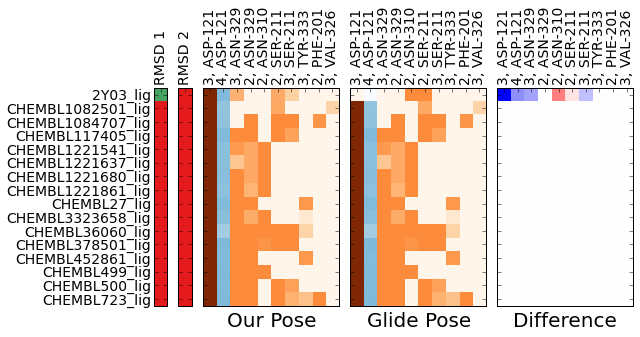

In [9]:
# look at the neighbors of a particular pose

ligand = '2Y03_lig'

pose1 = 19
t1 = 'Our Pose'
pose2 = 0
t2 = 'Glide Pose'

sq = all_score_query[ligand]
all_lig = [sq.l_q] + sorted(sq.l_i)

show_side_by_side(sq.pose_neighbors[pose1], sq.pose_neighbors[pose2], all_lig, t1, t2, num_i=10)

# 2,3 -- hydrogen bonds
# 4   -- salt bridge

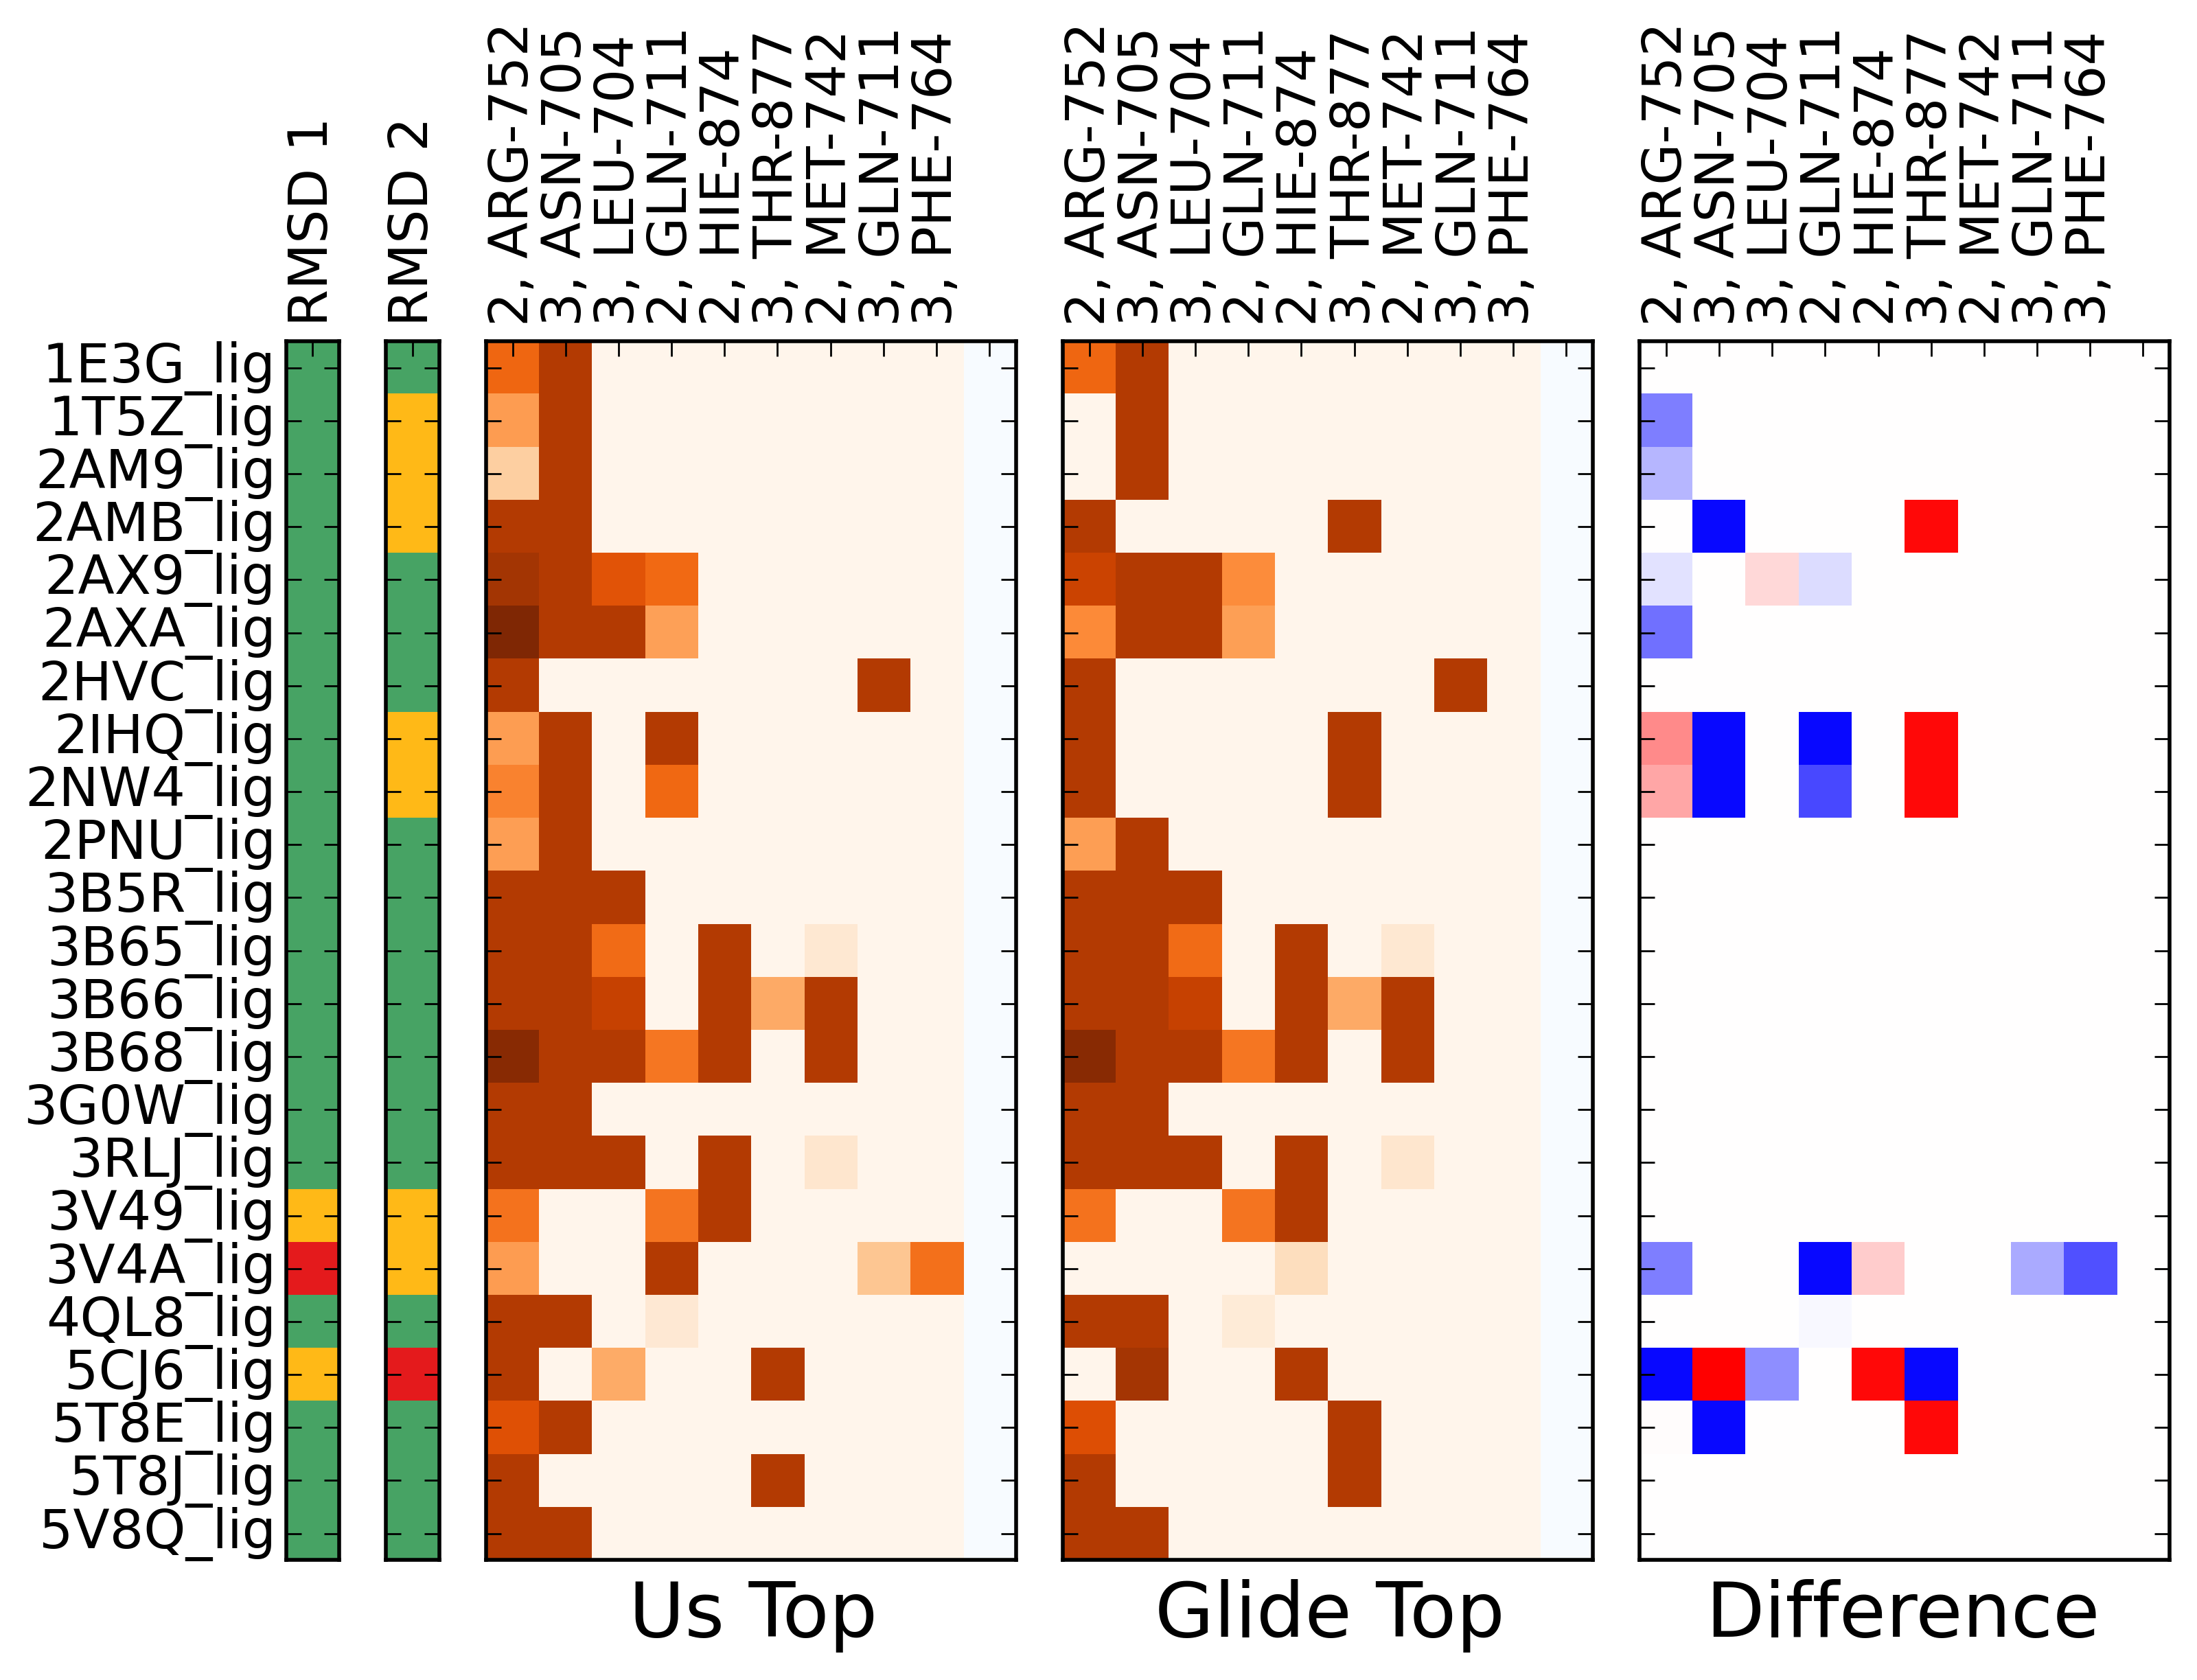

In [19]:
# top poses for a particular protein

#prot = 'B1AR'
prot = 'AR_final'
#prot = 'TRPV1'
lig_objs = d.all_proteins[prot].docking[(glide_dir, cross)].ligands

# a cluster is any mapping of ligand_name : PoseObject
# Poses can be found in lig_objs
# Poses have an rmsd, rank, gscore, fp

us_top_cluster = {}
glide_top_cluster = {}
for l in all_ligs[prot]:
    sq = all_score_query[l]
    
    us_pose_ranking = sorted(sq.pose_scores.keys(), key=lambda x: -1*sq.pose_scores[x])
    us_top_cluster[l] = lig_objs[l].poses[us_pose_ranking[0]]
    glide_top_cluster[l] = lig_objs[l].poses[0]
    
show_side_by_side(us_top_cluster, glide_top_cluster, all_ligs[prot], 'Us Top', 'Glide Top', num_i=10)

In [18]:
# export any set of poses. 
# output (should) show up in /scratch/PI/rondror/jbelk/outputs 

# prot = 'B1AR'
prot = 'TRPV1'

export(us_top_cluster, '{}-us-top'.format(prot), prot, struct=dock_st[prot])#, verbose=True)
export(glide_top_cluster, '{}-glide-top'.format(prot), prot, struct=dock_st[prot])#, verbose=True)